In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

In [2]:
# Import the relevant classes from 'qiskit_nature' package for quantum chemistry computations
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem

# Define the H_2 molecule geometry in equilibrium
geometry = [['H', [0., 0., -0.37]],
            ['H', [0., 0., 0.37]]]

# Create the molecule object
mol = Molecule(geometry=geometry, charge=0)

# Create the electronic structure driver
driver = ElectronicStructureMoleculeDriver(mol, basis='sto3g',
                                           driver_type=ElectronicStructureDriverType.PYSCF)

# Create the electronic structure problem
problem = ElectronicStructureProblem(driver)

# Compute the second-quantized operators
secqop = problem.second_q_ops()          # This is a dictionary object

# Print keys and values of secqop
for key, value in secqop.items():
    print(key, value)


ParticleNumber Fermionic Operator
register length=4, number terms=4
  (1+0j) * ( +_0 -_0 )
+ (1+0j) * ( +_1 -_1 )
+ (1+0j) * ( +_2 -_2 )
+ (1+0j) * ( +_3 -_3 )
ElectronicEnergy Fermionic Operator
register length=4, number terms=36
  -1.2533097866459775 * ( +_0 -_0 )
+ -0.47506884877217725 * ( +_1 -_1 )
+ -1.2533097866459775 * ( +_2 -_2 )
+ -0.47506884877217725 * ( +_3 -_3 )
+ -0.3373779634072241 * ( +_0 +_0 -_0 -_0 )
+ -0.0 ...
DipoleMomentX 0j
DipoleMomentY 0j
DipoleMomentZ Fermionic Operator
register length=4, number terms=4
  -0.9305563313489345 * ( +_0 -_1 )
+ -0.9305563313489345 * ( +_1 -_0 )
+ -0.9305563313489345 * ( +_2 -_3 )
+ -0.9305563313489345 * ( +_3 -_2 )
AngularMomentum Fermionic Operator
register length=4, number terms=12
  (0.75+0j) * ( +_0 -_0 )
+ (0.75+0j) * ( +_1 -_1 )
+ (0.75+0j) * ( +_2 -_2 )
+ (0.75+0j) * ( +_3 -_3 )
+ (0.5+0j) * ( +_0 -_0 +_1 -_1 )
+ (-1.5+0j) * ( +_0 -_0 +_2 -_2 )
+ (-0.5+0j) * ( +_0 -_0 + ...
Magnetization Fermionic Operator
register length=4, 

In [3]:
# We need to access the entry secqop[ElectronicEnergy], It gives a truncation of the Hamiltonian in the 
# creation-annihilation operator formalism
print(secqop['ElectronicEnergy'])



Fermionic Operator
register length=4, number terms=36
  -1.2533097866459775 * ( +_0 -_0 )
+ -0.47506884877217725 * ( +_1 -_1 )
+ -1.2533097866459775 * ( +_2 -_2 )
+ -0.47506884877217725 * ( +_3 -_3 )
+ -0.3373779634072241 * ( +_0 +_0 -_0 -_0 )
+ -0.0 ...


In [4]:
# Now we need to transform the Hamiltonian into a qubit Hamiltonian involving Pauli strings.
# We do so with the Jordan-Wigner transformation
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

mapper = JordanWignerMapper()
qubit_hamiltonian = mapper.map(secqop['ElectronicEnergy'])

# Print out our qubit Hamiltonian
print("Qubit Hamiltonian")
print(qubit_hamiltonian)

Qubit Hamiltonian
-0.8121706072487122 * IIII
+ 0.17141282644776915 * IIIZ
- 0.22343153690813483 * IIZI
+ 0.17141282644776915 * IZII
- 0.22343153690813483 * ZIII
+ 0.12062523483390415 * IIZZ
+ 0.16868898170361205 * IZIZ
+ 0.04530261550379923 * YYYY
+ 0.04530261550379923 * XXYY
+ 0.04530261550379923 * YYXX
+ 0.04530261550379923 * XXXX
+ 0.16592785033770338 * ZIIZ
+ 0.16592785033770338 * IZZI
+ 0.1744128761226159 * ZIZI
+ 0.12062523483390415 * ZZII


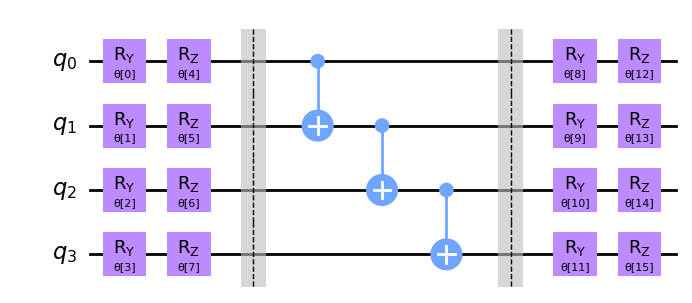

In [5]:

from qiskit.circuit.library import EfficientSU2

# Create an instance of the EfficientSU2 circuit
ansatz = EfficientSU2(num_qubits=4, reps=1, entanglement="linear",
insert_barriers = True)

# Decompose the circuit into its individual gates and draw it
ansatz.decompose().draw("mpl")

In [6]:
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.utils import algorithm_globals

# Search for better states using SPSA algorithm
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA()

# Set a seed for reproducibility
import numpy as np

seed = 1234
np.random.seed(seed)
algorithm_globals.random_seed = seed


# Initialize randomly the parameters for our ansatz
initial_point = np.random.random(ansatz.num_parameters)

print(initial_point)


[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581 0.27259261
 0.27646426 0.80187218 0.95813935 0.87593263 0.35781727 0.50099513
 0.68346294 0.71270203 0.37025075 0.56119619]


In [7]:
# Define the VQELog class and the 'update()' method within it. 

import time
from dataclasses import dataclass

@dataclass


class VQELog:
    values: list
    parameters: list
    times: list
    start_time: float = None  # Variable to store the start time of the VQE process

    def update(self, count, parameters, mean, _metadata):
        # Update the VQELog 
        self.values.append(mean)
        self.parameters.append(parameters)
        
        if self.start_time is None:
            # If start_time is not set, set it to the current time
            self.start_time = time.time()
            self.times.append(0) # Append 0 to the times list (for first update)
        else:
            # Compute the elapsed time
            self.times.append(time.time() - self.start_time)
        print(f"Running circuit {count}", end="\r", flush=True)
        

In [8]:
# Create an instance of the VQELog class
log = VQELog([], [], [])

In [9]:
# Perform a noiseless simulation of VQE

backend = "ibmq_qasm_simulator"

# Define a VQE instance
with Session(service=service, backend=backend) as session:
    options = Options()
    options.optimization_level = 0

    vqe = VQE(
        Estimator(session=session, options=options),
        ansatz,
        optimizer,
        callback=log.update,
        initial_point=initial_point,
    )
    result = vqe.compute_minimum_eigenvalue(qubit_hamiltonian)
    print("Experiment complete.".ljust(30))
    print(f"Raw result: {result.optimal_value}")

    if "simulator" not in backend:
        # Run once with ZNE error mitigation
        options.resilience_level = 2
        vqe = VQE(
            Estimator(session=session, options=options),
            ansatz,
            SPSA(1),
            initial_point=result.optimal_point,
        )
        result = vqe.compute_minimum_eigenvalue(qubit_hamiltonian)
        print(f"Mitigated result: {result.optimal_value}")

Experiment complete.          
Raw result: -1.8512258868150346


In [10]:
# Compute the ground state energy with classical methods
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
solver = NumPyMinimumEigensolver()
result = solver.compute_minimum_eigenvalue(qubit_hamiltonian)
print(result)

{   'aux_operators_evaluated': None,
    'eigenstate': Statevector([-1.53666363e-17-4.93701060e-20j,
             -4.57234900e-16-4.65250782e-16j,
              1.25565337e-17-2.11612780e-17j,
              4.73690908e-16-1.33060132e-16j,
              1.52564317e-16-1.40021223e-16j,
             -6.67316913e-01-7.36221442e-01j,
             -1.62999711e-16-2.24584031e-16j,
             -8.42710421e-17+6.43081213e-17j,
             -7.98957973e-17-1.35250844e-17j,
              1.90408979e-16+3.25517112e-16j,
              7.55826341e-02+8.33870007e-02j,
             -3.56170534e-17+9.82948865e-17j,
             -4.51619835e-16+1.70721750e-16j,
              1.91645940e-17-1.45775129e-16j,
             -4.79331105e-17+5.57184037e-17j,
             -3.62080563e-17+4.86380668e-17j],
            dims=(2, 2, 2, 2)),
    'eigenvalue': -1.852388173569583}


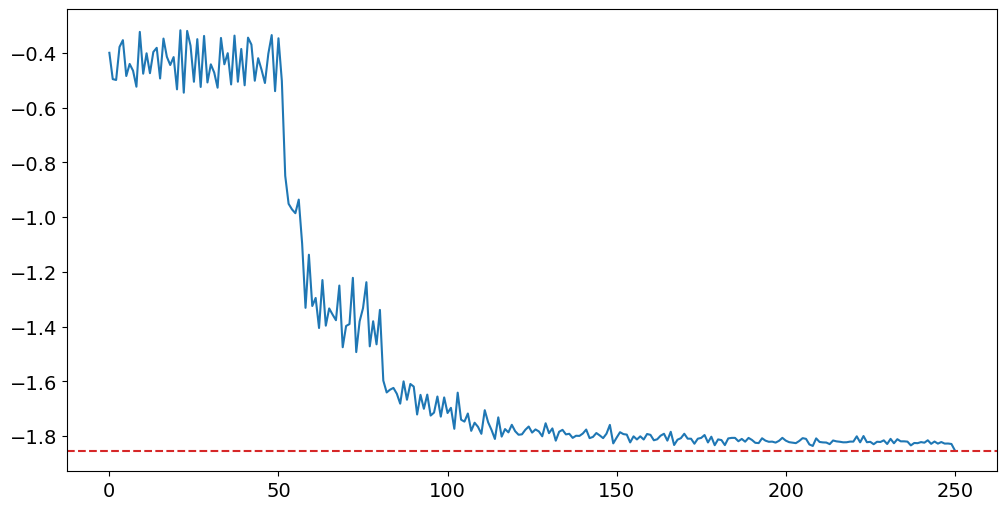

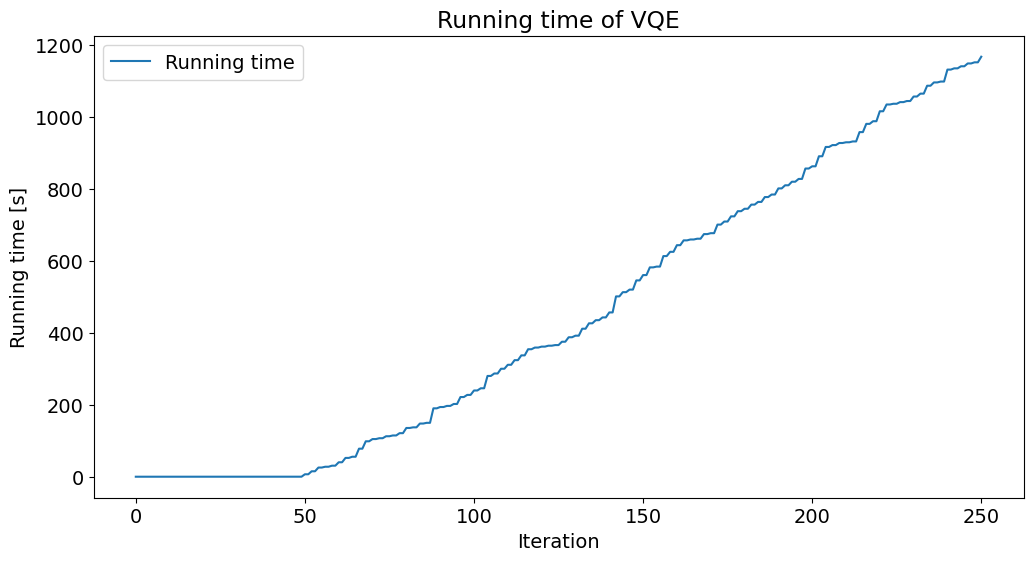

In [11]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 14

# Plot energy and reference value
plt.figure(figsize=(12, 6))
plt.plot(log.values, label="Estimator VQE")
plt.axhline(y=result.eigenvalue, color="tab:red", ls="--", label="Target")

# Add a plot for running time
plt.figure(figsize=(12, 6))
plt.plot(log.times, label="Running time")
plt.xlabel("Iteration")
plt.ylabel("Running time [s]")
plt.title("Running time of VQE")
plt.legend(loc="best")
plt.show()

In [18]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigo

# Use a fake provider to extract data from a real IBM Quantum device (Vigo)
device = FakeVigo()

# Retrieve the coupling map from the device configuration
coupling_map = device.configuration().coupling_map

# Create a noise model based on the characteristics of the device
noise_model = NoiseModel.from_backend(device)

print(noise_model)


NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'measure', 'sx', 'cx', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


In [19]:
from qiskit_aer.primitives import Estimator as AerEstimator
noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

In [20]:
log3 = VQELog([], [], [])

with Session(service=service, backend=backend) as session:
    options = Options()
    options.optimization_level = 3
    options.resilience_level = 2
    options.noise_model=noise_model
    vqe = VQE(
        Estimator(session=session, options=options),
        ansatz,
        optimizer,
        callback=log3.update,
        initial_point=initial_point,
    )
    result = vqe.compute_minimum_eigenvalue(qubit_hamiltonian)
    print("Experiment complete.".ljust(30))
    print(f"Raw result: {result.optimal_value}")

Experiment complete.          
Raw result: -1.85086412651438


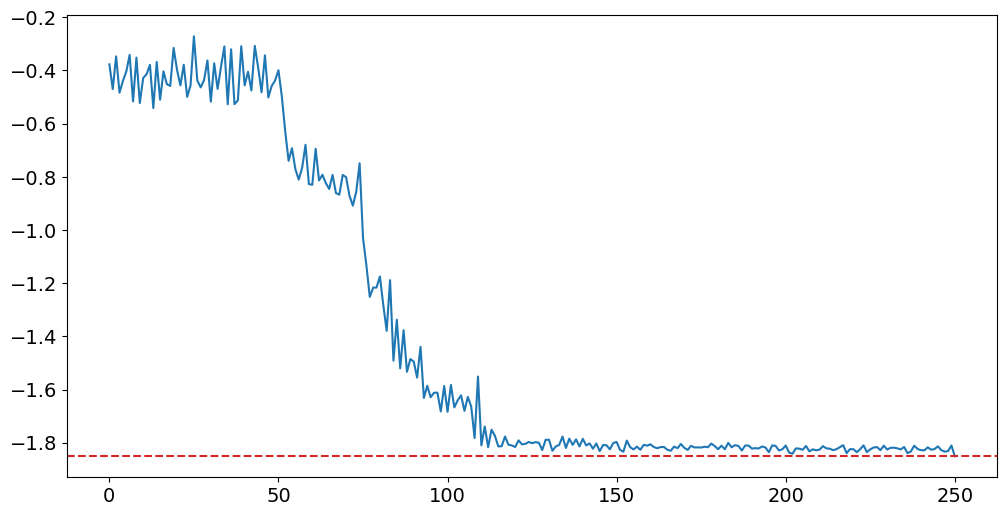

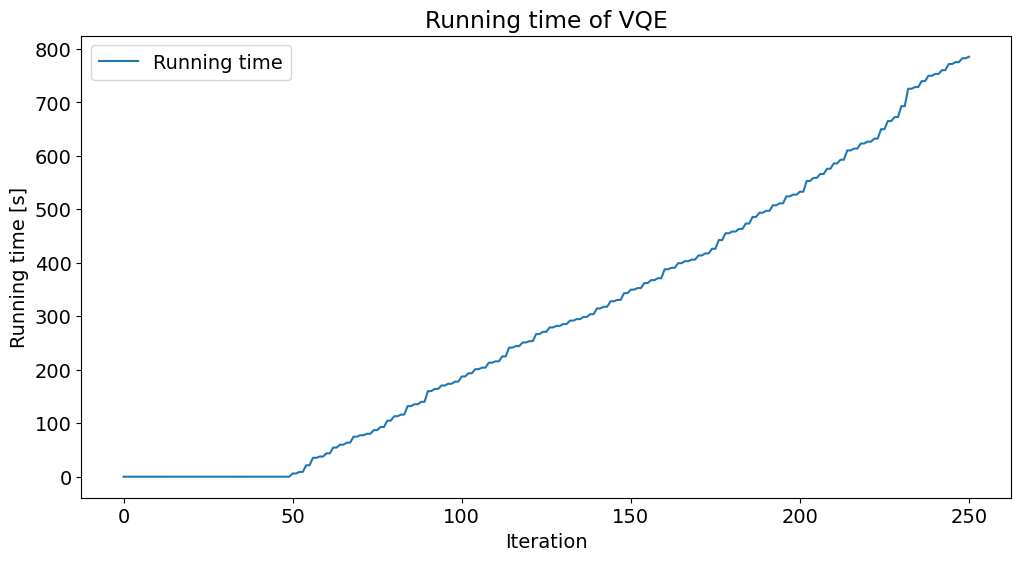

In [21]:
plt.rcParams["font.size"] = 14

# Plot energy and reference value
plt.figure(figsize=(12, 6))
plt.plot(log3.values, label="Estimator VQE")
plt.axhline(y=result.eigenvalue, color="tab:red", ls="--", label="Target")

# Plot running time
plt.figure(figsize=(12, 6))
plt.plot(log3.times, label="Running time")
plt.xlabel("Iteration")
plt.ylabel("Running time [s]")
plt.title("Running time of VQE")
plt.legend(loc="best")
plt.show()

In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Options

service = QiskitRuntimeService(channel="ibm_quantum")

#backend = "ibmq_qasm_simulator"
backend = "ibm_perth"

In [ ]:
log7 = VQELog([], [], [])

# Main calculation
with Session(service=service, backend=backend) as session:
    options = Options()
    options.resilience_level = 0
    vqe2 = VQE(
        Estimator(session=session, options=options),
        ansatz,
        optimizer,
        callback=log7.update,
        initial_point=initial_point
    )
    result = vqe2.compute_minimum_eigenvalue(qubit_hamiltonian)
    print(f">>> Job Status: {vqe2.status()}")
    print("Experiment complete.".ljust(30))
    print(result)